In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from textblob import TextBlob
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
import json
import io
import csv
import requests
import statistics
from wordcloud import WordCloud, STOPWORDS
import os
from PIL import Image
from IPython.display import display
import re

In [2]:
pd.set_option('mode.chained_assignment', None)

In [3]:
search = 'Avengers_Endgame'
response = requests.get('http://www.omdbapi.com/?t='+ search + '&plot=full&r=json&apikey=1564c91a')
data = response.json()

In [4]:
'''
access_token = "BLANK"
access_token_secret = "BLANK"
consumer_key = "BLANK"
consumer_secret = "BLANK"


class StdOutListener(StreamListener):
    def on_data(self, data):
        dictionary = json.loads(data)
        with io.open("newdata.txt", "a+", encoding="utf-8") as twitter_file:
            if dictionary['lang'] == 'en':
                row = dictionary['text']
                twitter_file.write(row + '/|\n')
                twitter_file.close()
        return True

    def on_error(self, status):
        print(status)


if __name__ == '__main__':
    listener = StdOutListener()
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    stream = Stream(auth, listener)
    stream.filter(track=['Avengers'])
'''

'\naccess_token = "BLANK"\naccess_token_secret = "BLANK"\nconsumer_key = "BLANK"\nconsumer_secret = "BLANK"\n\n\nclass StdOutListener(StreamListener):\n    def on_data(self, data):\n        dictionary = json.loads(data)\n        with io.open("newdata.txt", "a+", encoding="utf-8") as twitter_file:\n            if dictionary[\'lang\'] == \'en\':\n                row = dictionary[\'text\']\n                twitter_file.write(row + \'/|\n\')\n                twitter_file.close()\n        return True\n\n    def on_error(self, status):\n        print(status)\n\n\nif __name__ == \'__main__\':\n    listener = StdOutListener()\n    auth = OAuthHandler(consumer_key, consumer_secret)\n    auth.set_access_token(access_token, access_token_secret)\n    stream = Stream(auth, listener)\n    stream.filter(track=[\'Avengers\'])\n'

In [5]:
with io.open('newdata.txt', 'r', encoding="utf-8") as infile, io.open('text.csv', 'a', encoding="utf-8") as outfile:
    stripped = (line.strip() for line in infile)
    lines = (line.split("/|") for line in stripped if line)
    writer = csv.writer(outfile)
    writer.writerows(lines)

In [6]:
def word_remover(strings, excluders):
    temp_list = list(strings)
    for idx, y in enumerate(temp_list):
        for x in excluders:
            if x in y:
                y = y.replace(x, '')
                temp_list[idx] = y.replace(x, '')
    return(temp_list)

In [7]:
def text_splitter(list_input,splitter):
    new_list = []
    for text in list_input:
        head, sep, tail = text.partition(splitter)
        new_list.append(head)
    return(new_list)

In [8]:
def mean_getter(len_list,sen_list,range_start,range_end):
    avg_list = []
    for idx, length in enumerate(len_list):  
        if length in range(range_start,range_end):
            avg_list.append(sen_list[idx])
    return statistics.mean(avg_list)

In [9]:
twitter = pd.read_csv('text.csv', '\t')
stop = stopwords.words('english')
exclusions = pd.read_csv('marvel_actors.csv',header=0,encoding = 'unicode_escape')

In [10]:
length_list = []
for text in twitter['Tweet Text']:
    length_list.append(len(text))
twitter['Tweet Length'] = length_list

In [11]:
exclusions['Description'] = text_splitter(exclusions['Description'],'n\n')

In [12]:
exclusions = exclusions.drop(columns=['Position','Const','Created','Modified','Known For','Birth Date'])

In [13]:
exclusions['Description'] = exclusions['Description'].apply(lambda x: " ".join(x.lower() for x in x.split()))
exclusions['Description'] = exclusions['Description'].str.replace('[^\w\s]','')
exclusions['Name'] = exclusions['Name'].apply(lambda x: " ".join(x.lower() for x in x.split()))
exclusions['Name'] = exclusions['Name'].str.replace('[^\w\s]','')

In [14]:
twitter['Tweet Text'] = twitter['Tweet Text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [15]:
twitter['Tweet Text'] = twitter['Tweet Text'].str.replace('[^\w\s]','')

In [16]:
twitter['Tweet Text'] = twitter['Tweet Text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [17]:
#frequency = list(exclusions['Description'])
#twitter['Tweet Text'] = twitter['Tweet Text'].apply(lambda x: " ".join(x for x in x.split() if x not in frequency))

In [18]:
#frequency = pd.Series(' '.join(twitter['Tweet Text']).split()).value_counts()[-100:]

In [19]:
#frequency = list(frequency.index)
#twitter['Tweet Text'] = twitter['Tweet Text'].apply(lambda x: " ".join(x for x in x.split() if x not in frequency))

In [20]:
twitter['Tweet Text']=(word_remover(twitter['Tweet Text'], exclusions['Description']))

In [21]:
twitter['Tweet Text'] = (word_remover(twitter['Tweet Text'], exclusions['Name']))

In [22]:
#twitter

In [23]:
twitter['sentiment'] = twitter['Tweet Text'].apply(lambda x: TextBlob(x).sentiment[0])

In [24]:
#twitter[twitter['sentiment'] != 0][['Tweet Text', 'sentiment']].head(1000)

In [25]:
twitter['sentiment'].mean()

0.07236353288424113

In [26]:
twitter[twitter['sentiment'] != 0]['sentiment'].mean()

0.2617011461811999

In [27]:
rating = twitter[twitter['sentiment'] != 0]['sentiment'].mean() * 50 + 50

In [28]:
v1 = int(rating)

In [29]:
v2 = int(''.join(word_remover(data['Ratings'][0]['Value'],'%')))

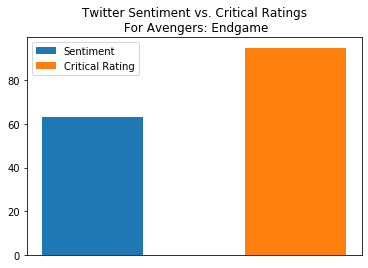

In [30]:
plt.bar(1,v1,label='Sentiment',width=0.5)
plt.bar(2,v2,label='Critical Rating',width=0.5)
plt.xlabel('Rating %')
plt.title('Twitter Sentiment vs. Critical Ratings\n For Avengers: Endgame')
plt.legend()
chart1 = plt.gca()
chart1.axes.get_xaxis().set_visible(False)
chart1

In [31]:
twitter[twitter['Tweet Length'] > 1]['Tweet Length'].mean()

80.30435130231557

In [32]:
print(twitter['Tweet Length'].max())

153


In [33]:
expansion_factor= 10**6
mean_list = [
    mean_getter(twitter['Tweet Length'],twitter['sentiment'],20, 40)*expansion_factor,
    mean_getter(twitter['Tweet Length'],twitter['sentiment'],40, 60)*expansion_factor,
    mean_getter(twitter['Tweet Length'],twitter['sentiment'],60, 80)*expansion_factor,
    mean_getter(twitter['Tweet Length'],twitter['sentiment'],80, 100)*expansion_factor,
    mean_getter(twitter['Tweet Length'],twitter['sentiment'],100, 120)*expansion_factor,
    mean_getter(twitter['Tweet Length'],twitter['sentiment'],140, 160)*expansion_factor
]
print(mean_list)

[51387.6302477033, 29420.750410192144, 59520.17639932415, 26099.291517973033, 94417.47503260436, 199545.6355126585]


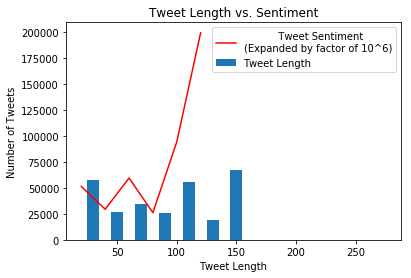

In [34]:
bins = [20,40,60,80,100,120,140,160,180,200,220,240,260,280]
plt.hist(twitter[twitter['Tweet Length'] > 1]['Tweet Length'], bins, histtype='bar', rwidth=0.5,label='Tweet Length')
plt.title('Tweet Length vs. Sentiment')
plt.ylabel('Number of Tweets')
plt.xlabel('Tweet Length')
plt.plot(bins[:len(mean_list)],mean_list,color='red',label='           Tweet Sentiment\n(Expanded by factor of 10^6)')
plt.legend()
plt.show()


In [35]:
frequency = pd.Series(' '.join(twitter['Tweet Text']).split()).value_counts()[:500]
type(frequency)
#frequency = frequency.tolist()
#type(frequency)
frequency_list = []
for i in frequency.index:
    frequency_list.append(i)

In [36]:
for idx,string in enumerate(frequency_list):
    if 'http' in string:
        del frequency_list[idx]

In [37]:
frequency_string = ""
for i in frequency_list:
    frequency_string += ((i) + ",")

In [38]:
def create_wordcloud(text):
    mask = np.array(Image.open("cloud.png"))
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color="white", mask =mask,max_words = 500, stopwords=stopwords)
    wc.generate(text)
    wc.to_file("wc.png")
    display(Image.open('wc.png'))

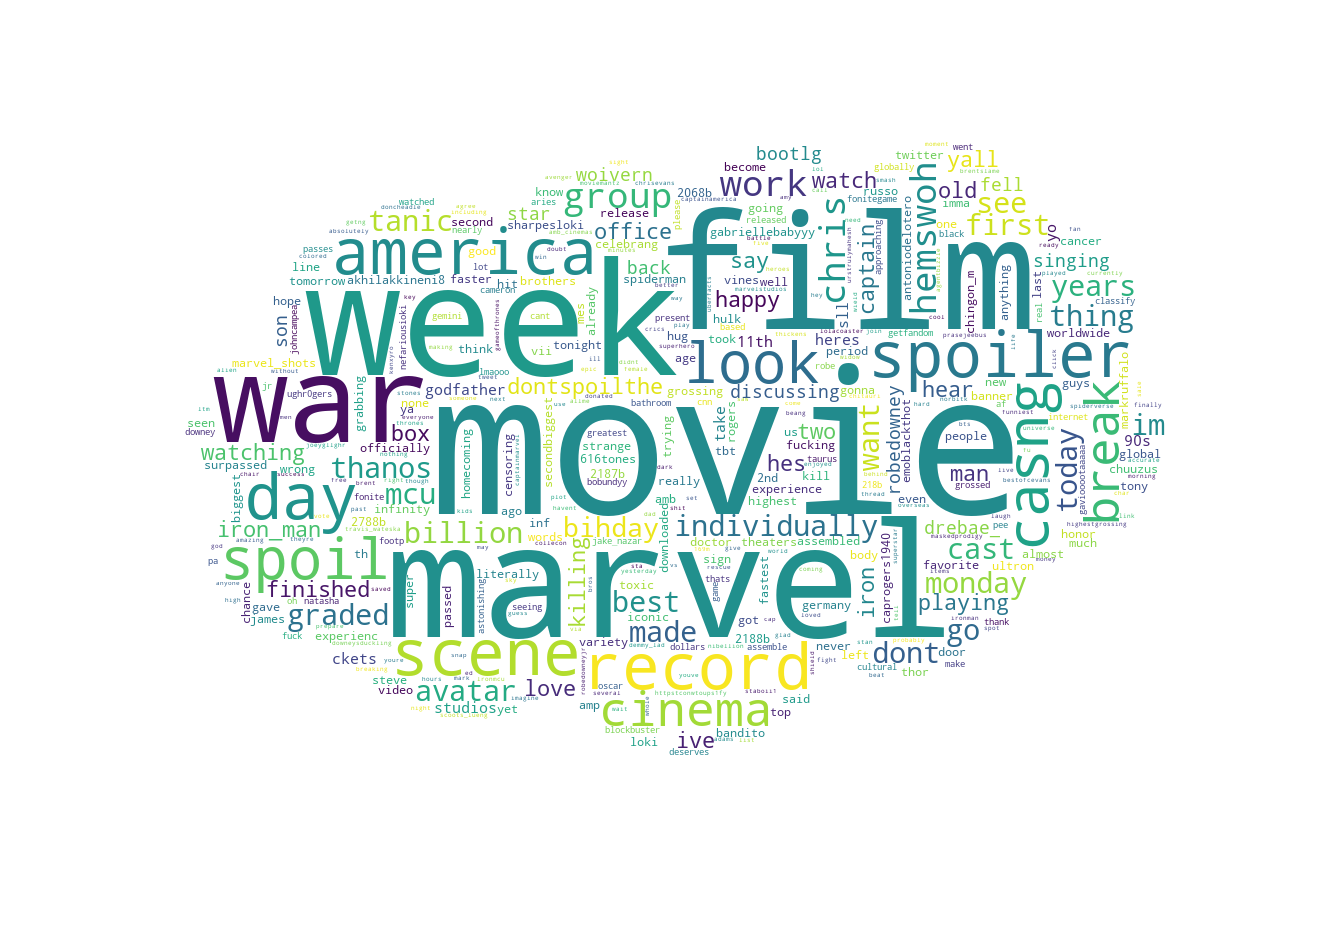

In [39]:
create_wordcloud(frequency_string)